100%|██████████| 50/50 [00:00<00:00, 77.65it/s]


(25000, 2)
(25000,)
(25000, 2)


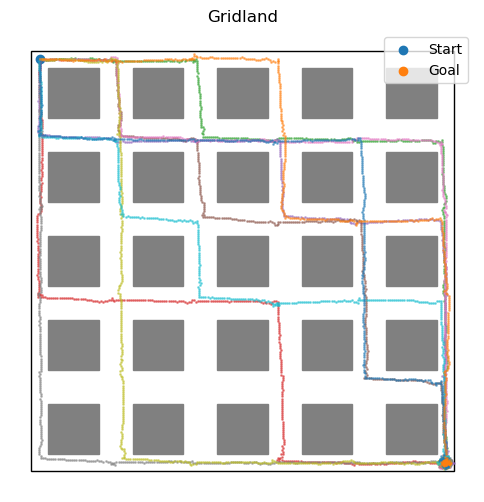

In [ ]:
# Imports, parameters, etc. 

### collects for single S-G pair - from top left to bottom right. 
# randomly varies which direction to go at keypoints
from gridland_environment import GridLand
from tqdm import trange
import numpy as np
import matplotlib.pyplot as plt


# various parameters
MAX_EP_LENGTH = 500 # should take ~450 steps 
TOTAL_SAMPLES =  25_000# OGBench had 1 million this seems reasonable eh
HOLDOUT_SPLIT = 0.3333
RANDOM_SEED = 42
save_directory = 'gridland_data_new'
SIZE = 5
keypoint_tolerance = 0.025 # for now set to same as env's goal tolerance who cares
gaussian_scale = 0.025 # random noise during action collection
save_directory = 'gridland_data_new'

# creates and resets the environment
env = GridLand(n_size=SIZE,timeout = MAX_EP_LENGTH)

# starts trajectory recording storage
obs_record = []
term_record = []
act_record = []

action = np.array((1,-1))
generator = np.random.default_rng(seed=RANDOM_SEED)
for episode in trange(int(TOTAL_SAMPLES/MAX_EP_LENGTH)):
    # initializes keypoint to wayfind to
    keypoint_ind = np.array([0,env.n_size])
    if generator.random() > 0.5:
        keypoint_ind[0] += 1
    else:
        keypoint_ind[1] -= 1
    keypoint = np.array((env.keypoints[keypoint_ind[0]],env.keypoints[keypoint_ind[1]]))
    at_keypoint = False
    truncated = False
    state, info = env.reset(start_idx='T0',goal_idx='B' + str(SIZE))
    while not truncated:
        obs_record.append(state)
        at_keypoint = np.linalg.norm(keypoint-state) <= keypoint_tolerance
        if at_keypoint:
            if keypoint_ind[0] < env.n_size and keypoint_ind[1] > 0:
                if generator.random() > 0.5 :
                    keypoint_ind[0] += 1
                else:
                    keypoint_ind[1] -= 1
            elif keypoint_ind[0] < env.n_size:
                keypoint_ind[0] += 1
            elif keypoint_ind[1] > 0:
                keypoint_ind[1] -= 1
            keypoint = np.array((env.keypoints[keypoint_ind[0]],env.keypoints[keypoint_ind[1]]))
        action = keypoint - state
        # adds small gaussian noise 
        action = action + generator.normal(loc=0,scale=gaussian_scale,size=action.shape)
        state, _, terminated, truncated, info = env.step(action)
        # recording
        term_record.append(truncated) # why this? sequence loader uses terminations as signs of traj. demarkation
        act_record.append(action)
fig, ax = env.get_mpl_plot()
obs_record = np.array(obs_record)
term_record = np.array(term_record)
act_record = np.array(act_record)
print(obs_record.shape)
print(term_record.shape)
print(act_record.shape)
# shows a little bit of visualization
for episode in range(int(10)):
    ax.scatter(obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,0],
               obs_record[episode*MAX_EP_LENGTH:(episode+1)*MAX_EP_LENGTH,1],s=1,alpha=0.5)
ax.legend()
save_dict = {'observations':obs_record,'terminals':term_record,'actions':act_record}
np.save(save_directory+'/dataset_n'+str(SIZE) +'.npy',save_dict)

In [2]:
print(obs_record.shape)

(100000, 2)
